Import all necessery libraries

In [85]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder,StandardScaler,OneHotEncoder,Normalizer,scale,MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

Importing Data

In [86]:
churn_data = pd.read_csv("churn_data.csv")
customer_data = pd.read_csv("customer_data.csv")
internet_data = pd.read_csv("internet_data.csv")

In [87]:
df_1 = pd.merge(churn_data, customer_data, how='inner', on='customerID')
telecom = pd.merge(df_1, internet_data, how='inner', on='customerID')

In [88]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
dtypes: float64(1), int64(2), obj

Converting data in suitable data type and categorising

In [89]:
telecom['TotalCharges'] =telecom['TotalCharges'].convert_objects(convert_numeric=True)

In [90]:
ordinal_attr = ['PhoneService','PaperlessBilling','Partner','Dependents','Churn']
dummy = ['Contract','PaymentMethod','gender','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
num_attr = telecom.select_dtypes(include=[np.number]).columns

Creating pipelines for column transformation

In [91]:
num_pipeline = Pipeline([
    ('imputer' , SimpleImputer(strategy='median')),
    ('std_scale',MinMaxScaler(feature_range = (-1,1)))
])

In [92]:
ordinal_pipeline = Pipeline([
    ('ordinal',OrdinalEncoder())
])

In [93]:
categorical_pipeline = Pipeline([
    ('dummy',OneHotEncoder(drop='first',sparse = False,dtype = np.int))
])

In [94]:
full_pipeline = ColumnTransformer([
    ('num',num_pipeline,num_attr),
    ('ordinal',ordinal_pipeline,ordinal_attr),
    ('cat',OneHotEncoder(drop='first',sparse = False),dummy)
])
testing = full_pipeline.fit_transform(telecom)

Creating a DataFrame to implement classification model

In [95]:
cat_names = full_pipeline.named_transformers_.cat.get_feature_names(dummy)

In [96]:
testing = pd.DataFrame(testing,columns = list(num_attr)+ordinal_attr+list(cat_names))

In [97]:
testing_churn = testing[['Churn']]

In [98]:
testing_data = testing
testing_data.drop('Churn',axis = 1, inplace=True)

Splitting DataFrame using train_test_split & Feature Selection

In [99]:
x_train,x_test,y_train,y_test = train_test_split(testing_data,testing_churn,random_state = 0)

In [100]:
import statsmodels.api as sm
logm1 = sm.GLM(y_train,(sm.add_constant(x_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 5282
Model:                            GLM   Df Residuals:                     5258
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2155.3
Date:                Sun, 10 May 2020   Deviance:                       4310.6
Time:                        18:28:11   Pearson chi2:                 5.95e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.7244      0.834     -0.869      0.385      -2.359       0.910
tenure                                   -2.1553      0.258     -8.347      0.000      -2.661      -1.649
MonthlyCharges                           -0.3518      1.859     -0.189      0.850      -3.996       3.292
TotalCharges                              1.3214      0.355      3.726      0.000       0.626       2.016
SeniorCitizen                             0.1326      0.050      2.669      0.008       0.035       0.230
PhoneService                             -0.6147      0.108     -5.711      0.000      -0.826      -0.404
PaperlessBilling                          0.3402      0.087      3.909      0.000       0.170       0.511
Partner                                   0.0267      0.091      0.294      0.769      -0.151       0.205
Dependents                               -0.1919      0.105     -1.831      0.067      -0.397       0.013
Contract_One year                        -0.7641      0.127     -6.001      0.000      -1.014      -0.515
Contract_Two year                        -1.3953      0.207     -6.731      0.000      -1.802      -0.989
PaymentMethod_Credit card (automatic)    -0.1502      0.135     -1.114      0.265      -0.414       0.114
PaymentMethod_Electronic check            0.3421      0.111      3.093      0.002       0.125       0.559
PaymentMethod_Mailed check               -0.0264      0.133     -0.198      0.843      -0.288       0.235
gender_Male                              -0.0843      0.075     -1.117      0.264      -0.232       0.064
MultipleLines_No phone service           -0.1097      0.789     -0.139      0.890      -1.657       1.437
MultipleLines_Yes                         0.3887      0.205      1.896      0.058      -0.013       0.790
InternetService_Fiber optic               0.9263      0.929      0.997      0.319      -0.895       2.748
InternetService_No                       -0.1258      0.135     -0.935      0.350      -0.390       0.138
OnlineSecurity_No internet service       -0.1258      0.135     -0.935      0.350      -0.390       0.138
OnlineSecurity_Yes                       -0.3506      0.208     -1.683      0.092      -0.759       0.058
OnlineBackup_No internet service         -0.1258      0.135     -0.935      0.350      -0.390       0.138
OnlineBackup_Yes                         -0.2293      0.204     -1.123      0.261      -0.629       0.171
DeviceProtection_No internet service     -0.1258      0.135     -0.935      0.350      -0.390       0.138
DeviceProtection_Yes                      0.0149      0.205      0.073      0.942      -0.387       0.417
TechSupport_No internet service          -0.1258      0.135     -0.935      0.350      -0.390       0.138
TechSuppo

Droping High inter-corelated data 

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

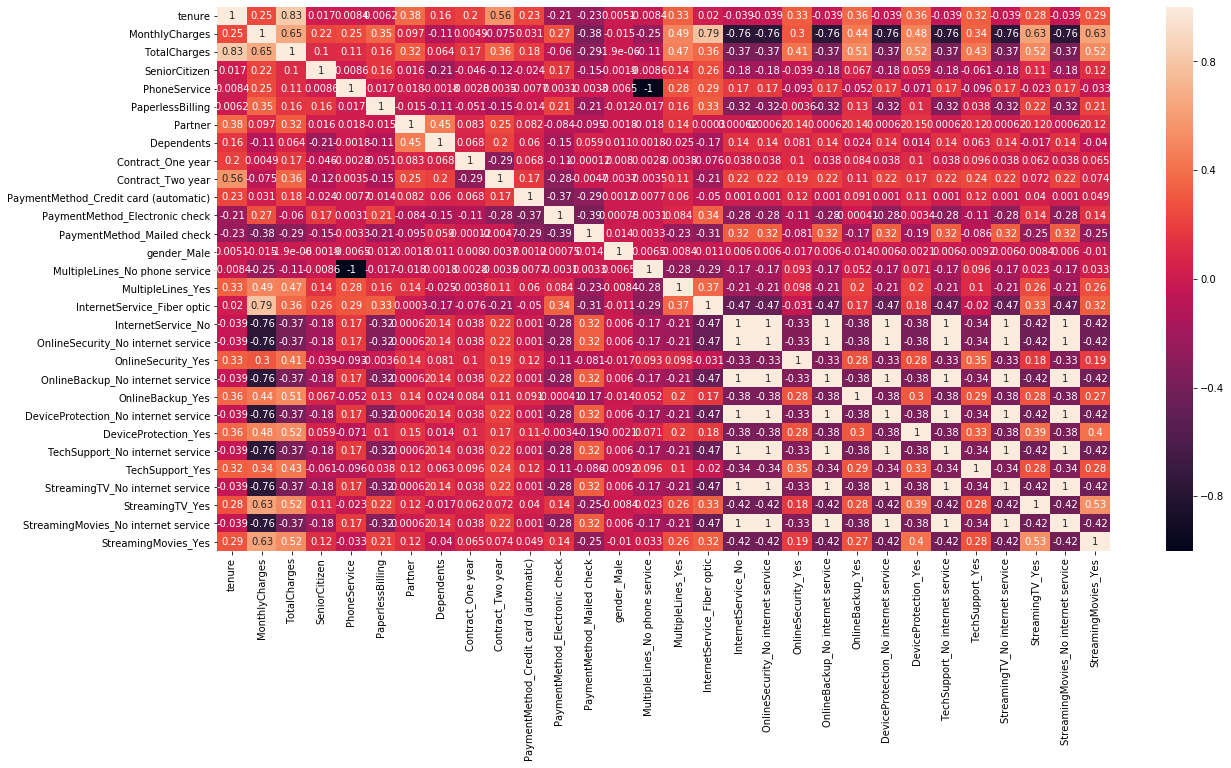

In [102]:
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(testing.corr(),annot = True)

In [103]:
x_train = x_train.drop(['InternetService_No','OnlineSecurity_No internet service','DeviceProtection_No internet service','TechSupport_No internet service','StreamingTV_No internet service','StreamingMovies_No internet service'],1)

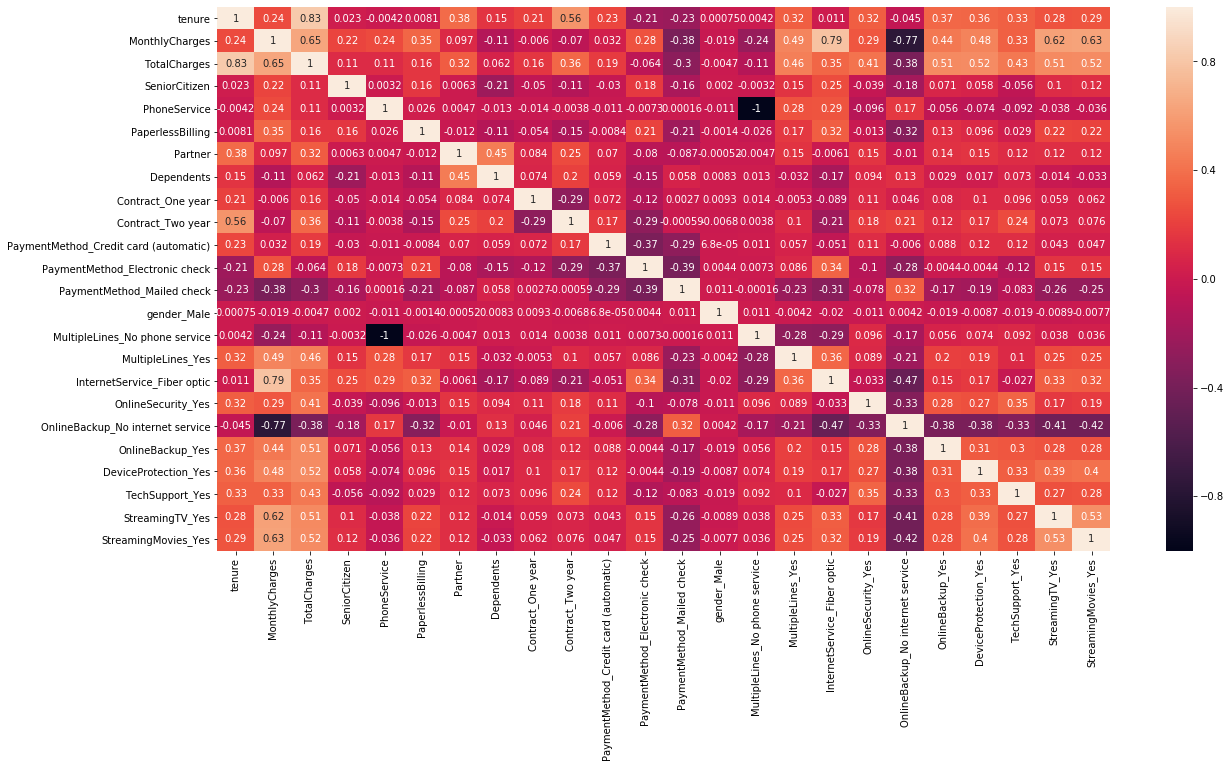

In [104]:
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(x_train.corr(),annot = True)

In [105]:
logm2 = sm.GLM(y_train,(sm.add_constant(x_train)), family = sm.families.Binomial())
logm2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 5282
Model:                            GLM   Df Residuals:                     5258
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2155.3
Date:                Sun, 10 May 2020   Deviance:                       4310.6
Time:                        18:28:26   Pearson chi2:                 5.95e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.7244      0.834     -0.869      0.385      -2.359       0.910
tenure                                   -2.1553      0.258     -8.347      0.000      -2.661      -1.649
MonthlyCharges                           -0.3518      1.859     -0.189      0.850      -3.996       3.292
TotalCharges                              1.3214      0.355      3.726      0.000       0.626       2.016
SeniorCitizen                             0.1326      0.050      2.669      0.008       0.035       0.230
PhoneService                             -0.6147      0.108     -5.711      0.000      -0.826      -0.404
PaperlessBilling                          0.3402      0.087      3.909      0.000       0.170       0.511
Partner                                   0.0267      0.091      0.294      0.769      -0.151       0.205
Dependents                               -0.1919      0.105     -1.831      0.067      -0.397       0.013
Contract_One year                        -0.7641      0.127     -6.001      0.000      -1.014      -0.515
Contract_Two year                        -1.3953      0.207     -6.731      0.000      -1.802      -0.989
PaymentMethod_Credit card (automatic)    -0.1502      0.135     -1.114      0.265      -0.414       0.114
PaymentMethod_Electronic check            0.3421      0.111      3.093      0.002       0.125       0.559
PaymentMethod_Mailed check               -0.0264      0.133     -0.198      0.843      -0.288       0.235
gender_Male                              -0.0843      0.075     -1.117      0.264      -0.232       0.064
MultipleLines_No phone service           -0.1097      0.789     -0.139      0.890      -1.657       1.437
MultipleLines_Yes                         0.3887      0.205      1.896      0.058      -0.013       0.790
InternetService_Fiber optic               0.9263      0.929      0.997      0.319      -0.895       2.748
OnlineSecurity_Yes                       -0.3506      0.208     -1.683      0.092      -0.759       0.058
OnlineBackup_No internet service         -0.8809      0.942     -0.935      0.350      -2.727       0.965
OnlineBackup_Yes                         -0.2293      0.204     -1.123      0.261      -0.629       0.171
DeviceProtection_Yes                      0.0149      0.205      0.073      0.942      -0.387       0.417
TechSupport_Yes                          -0.2943      0.210     -1.398      0.162      -0.707       0.118
StreamingTV_Yes                           0.3158      0.380      0.831      0.406      -0.429       1.060
StreamingMovies_Yes                       0.1895      0.380      0.499      0.618      -0.555       0.933
=========================================================================================================
"""

Feature Selection using RFE with Logistic Regression Model

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

In [107]:
log = LogisticRegression()
rfe = RFE(log,13)
rfe.fit(x_train,y_train)
col = list(rfe.support_)

In [108]:
val = pd.DataFrame({'name':list(x_train.columns),'val':col})

In [109]:
val = pd.DataFrame({'name':list(x_train.columns),'val':col})

Keeping only top 13 values based on p-values

In [110]:
keep = list(val[val.val==True].name)

Training a Logistic Regression Model

In [111]:
log2 = LogisticRegression().fit(x_train[keep],y_train)
y_pred = log2.predict(x_test[keep])

Creating a dataframe of values to compare with actual value and predict probability 

In [112]:
y_predprob = log2.predict_proba(x_test[keep])
y_pred_df = pd.DataFrame(y_predprob)
y_pred_1 = y_pred_df.iloc[:,[1]]
y_test_df = pd.DataFrame(y_test)
y_test_df['CustID'] = y_test_df.index
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
y_pred_final= y_pred_final.rename(columns={ 1 : 'Churn_Prob'})
y_pred_final = y_pred_final.reindex_axis(['CustID','Churn','Churn_Prob'], axis=1)
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)
accuracy_score( y_pred_final.Churn, y_pred_final.predicted)

0.7955706984667802

Custom function to get the ROC AUC curve

In [113]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 4))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

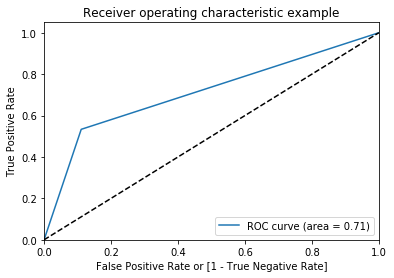

(array([0.        , 0.11093991, 1.        ]),
 array([0.        , 0.53347732, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [114]:
draw_roc(y_pred_final.Churn, y_pred_final.predicted)

Using previously created data frame to get a accurate cut-off point using predict_proba

In [115]:
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.Churn_Prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

,CustID,Churn,Churn_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,2200,0.0,0.135378,0,1,1,0,0,0,0,0,0,0,0
1,4627,0.0,0.118126,0,1,1,0,0,0,0,0,0,0,0
2,3225,0.0,0.439708,0,1,1,1,1,1,0,0,0,0,0
3,2828,0.0,0.056929,0,1,0,0,0,0,0,0,0,0,0
4,3768,0.0,0.192668,0,1,1,0,0,0,0,0,0,0,0


In [116]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_pred_final.Churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.262919  1.000000  0.000000
0.1   0.1  0.600795  0.922246  0.486133
0.2   0.2  0.700738  0.838013  0.651772
0.3   0.3  0.754117  0.747300  0.756549
0.4   0.4  0.788756  0.665227  0.832820
0.5   0.5  0.795571  0.533477  0.889060
0.6   0.6  0.794435  0.375810  0.943760
0.7   0.7  0.768881  0.181425  0.978428
0.8   0.8  0.739920  0.010799  1.000000
0.9   0.9  0.737081  0.000000  1.000000


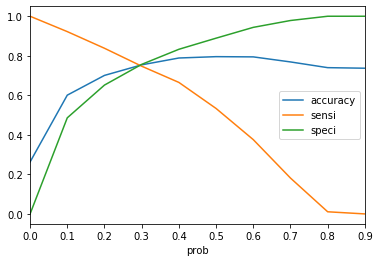

In [117]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

In [118]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.3 else 0)

In [119]:
metrics.accuracy_score( y_pred_final.Churn, y_pred_final.final_predicted)

0.7541169789892107